In [1]:
import pandas as pd
import numpy as np

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings("ignore")

## Austin Dataset

In [2]:
austin = pd.read_csv('data/austin_dw.csv')

In [3]:
austin['gender'].fillna('unknown', inplace=True)
austin['intake_repro'].fillna('unknown', inplace=True)
austin['outcome_repro'].fillna('unknown', inplace=True)
austin['age_days'].fillna(austin['age_days'].median(), inplace=True)

In [4]:
# set final variables as categorical
for col in ['intake_type', 'intake_condition', 
            'intake_repro','gender','outcome_repro']:
    austin[col] = austin[col].astype('category')

In [5]:
austin = pd.get_dummies(austin, columns=['gender','intake_condition','intake_repro','intake_type'])
austin.drop(['gender_unknown','intake_repro_unknown',
             'intake_condition_other','intake_type_euthanasia request'], inplace=True, axis=1)

In [6]:
# Split the data into a training and test dataset partitioning 75% of the data into the training data, and
# holding out 25% of the data as a test set. Set a seed to replicate your split using 202011.

y = austin[['euthanasia']]
X = austin.drop(columns=['euthanasia', 'animal_id','intake_date','outcome_date', 'city', 'outcome_repro', 'outcome_age'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=1137)

In [7]:
train_X.sample(10)

,days_in,age_days,affenpinscher,afghan hound,airedale terrier,akbash,akita,australian shepherd,alaskan husky,alaskan klee kai,...,intake_condition_healthy,intake_condition_injured,intake_condition_pregnant/nursing,intake_condition_sick,intake_condition_unhealthy,intake_repro_altered,intake_repro_intact,intake_type_owner surrender,intake_type_public assist,intake_type_stray
34542,53.0,730.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
68307,2.0,365.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
41646,5.0,30.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
37502,1.0,90.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
7900,3.0,180.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
82117,-1004.0,1460.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
43780,1.0,3650.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
64930,160.0,90.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
33338,32.0,30.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
27157,3.0,1460.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0


In [9]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=3711)

pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

In [10]:


search_space = [
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[4],
    'model__n_estimators':[1500]}
    
]

search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)



In [11]:
search.fit(train_X,train_y.euthanasia)

GridSearchCV(cv=KFold(n_splits=10, random_state=3711, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [RandomForestClassifier(max_depth=4,
                                                           n_estimators=1500)],
                          'model__max_depth': [4],
                          'model__n_estimators': [1500]}],
             scoring='roc_auc')

In [12]:
search.best_score_

0.8242570529333607

In [13]:
search.best_params_

{'model': RandomForestClassifier(max_depth=4, n_estimators=1500),
 'model__max_depth': 4,
 'model__n_estimators': 1500}

In [14]:
rf_mod = search.best_estimator_

In [15]:
m.roc_auc_score(train_y,rf_mod.predict_proba(train_X)[:,1])

0.8375476601965478

In [16]:
m.accuracy_score(train_y,rf_mod.predict(train_X))

0.9803384248620618

### Create Table of Mean Test Scores for Model Comparison

In [225]:
scores = search.cv_results_.get('mean_test_score')

In [226]:
#search.cv_results_.get('params')
models = [
    'GaussianNB',
    'KNN, neighbors:5',
    'KNN, neighbors:10',
    'KNN, neighbors:25',
    'KNN, neighbors:50',
    'DecisionTree, maxdepth:2',
    'DecisionTree, maxdepth:3',
    'DecisionTree, maxdepth:4',
    'RandomForest, maxdepth:2, trees:500',
    'RandomForest, maxdepth:2, trees:1000',
    'RandomForest, maxdepth:2, trees:1500',
    'RandomForest, maxdepth:3, trees:500',
    'RandomForest, maxdepth:3, trees:1000',
    'RandomForest, maxdepth:3, trees:1500',
    'RandomForest, maxdepth:4, trees:500',
    'RandomForest, maxdepth:4, trees:1000',
    'RandomForest, maxdepth:4, trees:1500'
]

In [227]:
d = {'model':models, 'mean_test_score':scores}
table = pd.DataFrame(data=d)


In [228]:
table

,model,mean_test_score
0,GaussianNB,0.517262
1,"KNN, neighbors:5",0.628273
2,"KNN, neighbors:10",0.672586
3,"KNN, neighbors:25",0.726415
4,"KNN, neighbors:50",0.745051
5,"DecisionTree, maxdepth:2",0.711344
6,"DecisionTree, maxdepth:3",0.765437
7,"DecisionTree, maxdepth:4",0.795708
8,"RandomForest, maxdepth:2, trees:500",0.814144
9,"RandomForest, maxdepth:2, trees:1000",0.814582


In [224]:
table.to_csv('model_test_score_table.csv', index=False)

## Feature Importance

In [19]:


vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=5)



# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat



,variable,vi,std,low,high
0,days_in,0.0,0.0,0.0,0.0
1,saluki,0.0,0.0,0.0,0.0
2,polish lowland,0.0,0.0,0.0,0.0
3,pomeranian,0.0,0.0,0.0,0.0
4,toy poodle,0.0,0.0,0.0,0.0
...,...,...,...,...,...
249,feist,0.0,0.0,0.0,0.0
250,field spaniel,0.0,0.0,0.0,0.0
251,fila brasileiro,0.0,0.0,0.0,0.0
252,finnish spitz,0.0,0.0,0.0,0.0


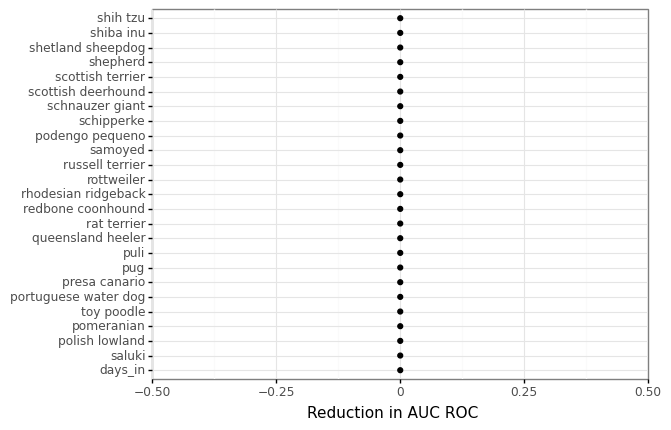

<ggplot: (8782119302660)>

In [23]:

# Plot
(
    ggplot(vi_dat[0:25],
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat[0:25].variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)



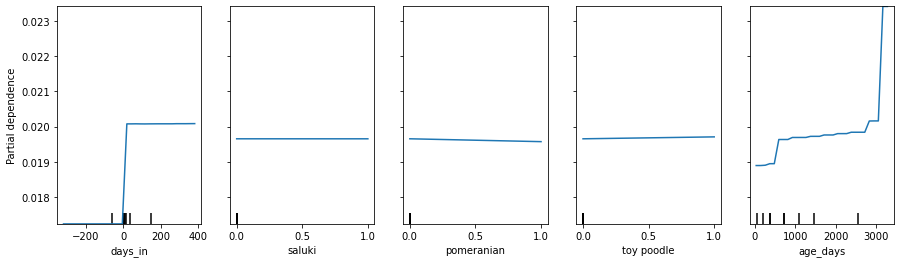

In [25]:


# Target specific features
features = ['days_in', 'saluki','pomeranian', 'toy poodle', 'age_days']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(15, 4))
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)


plt.savefig("figure_1.png", dpi=300, transparent=False, facecolor='white',edgecolor='white')